In [411]:
import pandas as pd
import numpy as np
import random
import jieba
import jieba.posseg as pseg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei'] # 解决中文显示问题
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [412]:
all_data = pd.read_excel('C:\\Users\WENDY\\Desktop\\消费者行为分析\\课业2019\\消费贷款数据.xlsx')
# 替换nan为0
#all_data.where(all_data.notnull(), 0)
all_data = all_data.fillna(0)

columns_name = all_data.columns.tolist()
columns_name

['公司名称',
 '城市',
 '贷款金额',
 '期限',
 '月供',
 '还款总费用',
 '月管理费',
 '期限最低范围',
 '期限最高范围',
 '还款方式',
 '放款日期',
 '审批时间',
 '担保方式',
 '申请人数',
 '申请条件']

In [413]:
all_data.head()

,公司名称,城市,贷款金额,期限,月供,还款总费用,月管理费,期限最低范围,期限最高范围,还款方式,放款日期,审批时间,担保方式,申请人数,申请条件
0,中腾信金融信息服务（上海）有限公司北京分公司,北京,10万元,12月,9225,1.07,月管理费 1.60%,1,12,分期还款,1,1.0,信用贷,198,北京牌照车辆、全款车、购买三个月以上1、名下有北京牌照车辆2、全款车、购买三个月以上3、信用...
1,北京森强国际投资担保有限公司,北京,10万元,12月,10046,2.06,月管理费 3.00%,1,120,到期还款,1,1.0,抵押贷,44,名下有车、北京牌照、有稳定还款来源1、名下有车2、北京牌照3、有稳定还款来源温馨提示：名下有...
2,北京博瑞奕华投资有限公司,北京,10万元,12月,9333,1.20,参考月利率 1.00%,1,36,分期还款,3,1.0,信用贷,308,中国合法公民、18-60周岁、信用良好1、中国合法公民2、年龄在18-60岁3、具有完全民事...
3,北京博瑞奕华投资有限公司,北京,10万元,12月,8885,1.06,参考月利率 1.00%,1,12,到期还款,15,10.0,抵押贷,0,1、公司五证2、个人信息材料3、公司往来合同4、银行流水5、财务报表6、资产证明
4,北京中金行投资管理有限公司,北京,10万元,12月,9749,1.70,月管理费 2.50%,1,36,分期还款,1,1.0,抵押贷,0,1、身份证、户口本2、结婚证3、收入证明、房产证明或资产证明等


In [414]:
# 月管理费
yglf_num = []
yglf_type = []
for i in all_data['月管理费'].tolist():
    i = i.split()
    yglf_type.append(i[0])
    yglf_num.append(float(i[-1][:-1]))
    
print(yglf_num[:5])
print(yglf_type[:5])

[1.6, 3.0, 1.0, 1.0, 2.5]
['月管理费', '月管理费', '参考月利率', '参考月利率', '月管理费']


In [415]:
fkrq = all_data['放款日期'].values.tolist()
ind = fkrq.index('审批后当日（审批为3')
fkrq[ind] = 4

In [416]:
# 处理哑变量
from patsy import dmatrices

In [418]:
# 城市 还款方式 担保方式 贷款金额 期限 月管理费

all_data1 = all_data.copy(deep=True)
all_data1['月管理费类型'] = yglf_type
all_data1['月管理费利率']   = yglf_num
all_data1['放款日期']   = fkrq


# 对申请人数就取ln（），结果变好
all_data1['申请人数']   = np.log(all_data1['申请人数'])
all_data1['申请人数'][np.isinf(all_data1['申请人数'])] = 0


#训练模型
##多个自变量回归
###分训练集，测试集
####由于经常使用ML和DL的习惯，我习惯了先拆分数据集，后来发现其实线性回归不需要拆分数据集
####在计算指标的时候，直接使用train data即可

random.seed(1) #设立随机数种子
random_data = random.sample(range(len(all_data1)), round(len(all_data1)*0.2))
test_data=[]

for i in random_data:
    test_data.append(all_data1.iloc[i])
    
test_data=pd.DataFrame(test_data)
train_data = all_data1.drop(random_data)

#重新排列index
for i in [test_data, train_data]:
    i.index = range(i.shape[0])

train_data.head()

C:\Users\WENDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\WENDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,公司名称,城市,贷款金额,期限,月供,还款总费用,月管理费,期限最低范围,期限最高范围,还款方式,放款日期,审批时间,担保方式,申请人数,申请条件,月管理费类型,月管理费利率
0,中腾信金融信息服务（上海）有限公司北京分公司,北京,10万元,12月,9225,1.07,月管理费 1.60%,1,12,分期还款,1,1.0,信用贷,5.288267,北京牌照车辆、全款车、购买三个月以上1、名下有北京牌照车辆2、全款车、购买三个月以上3、信用...,月管理费,1.60
1,北京森强国际投资担保有限公司,北京,10万元,12月,10046,2.06,月管理费 3.00%,1,120,到期还款,1,1.0,抵押贷,3.784190,名下有车、北京牌照、有稳定还款来源1、名下有车2、北京牌照3、有稳定还款来源温馨提示：名下有...,月管理费,3.00
2,北京博瑞奕华投资有限公司,北京,10万元,12月,9333,1.20,参考月利率 1.00%,1,36,分期还款,3,1.0,信用贷,5.730100,中国合法公民、18-60周岁、信用良好1、中国合法公民2、年龄在18-60岁3、具有完全民事...,参考月利率,1.00
3,阳光保险集团股份有限公司北京分公司,北京,10万元,12月,10483,2.58,月管理费 2.15%,1,36,分期还款,3,2.0,信用贷,0.000000,1、工作证明2、住址证明3、身份证复印件4、银行流水,月管理费,2.15
4,宜信普惠信息咨询（北京）有限公司,北京,10万元,12月,10713,2.86,月管理费 2.38%,1,12,分期还款,1,1.0,抵押贷,8.964568,22-55周岁、本人名下有车、车辆未被抵押1、22-55周岁2、车牌且须在申请人本人名下3、...,月管理费,2.38


In [419]:
train_y, train_x = dmatrices("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类型 + 月管理费利率""", data = train_data, return_type = 'dataframe')

#x['月供']           = all_data['月供']
#x['还款总费用']     = all_data['还款总费用']
#x['期限最低范围']   = all_data['期限最低范围']
#x['期限最高范围']   = all_data['期限最高范围']
#x['放款日期']       = all_data['放款日期']
#x['审批时间']       = all_data['审批时间']
#x['月管理费利率']   = yglf_num


In [420]:
# 显示x
train_x.head()

,Intercept,城市[T.北京],城市[T.南京],城市[T.天津],城市[T.广州],城市[T.成都],城市[T.杭州],城市[T.济南],城市[T.深圳],城市[T.西安],...,担保方式[T.自由选],月管理费类型[T.参考月利率],月管理费类型[T.月管理费],月供,还款总费用,期限最低范围,期限最高范围,放款日期,审批时间,月管理费利率
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,9225.0,1.07,1.0,12.0,1.0,1.0,1.60
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,10046.0,2.06,1.0,120.0,1.0,1.0,3.00
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,9333.0,1.20,1.0,36.0,3.0,1.0,1.00
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,10483.0,2.58,1.0,36.0,3.0,2.0,2.15
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,10713.0,2.86,1.0,12.0,1.0,1.0,2.38


In [421]:
#显示y
train_y.head()

,申请人数
0,5.288267
1,3.784190
2,5.730100
3,0.000000
4,8.964568


In [422]:
lm_cate = sm.OLS(train_y, train_x).fit()
lm_cate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.325
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           1.05e-07
Time:                        12:05:15   Log-Likelihood:                -2115.6
No. Observations:                 837   AIC:                             4283.
Df Residuals:                     811   BIC:                             4406.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.0249     17.524     -0.058      0.953     -35.423      33.373
城市[T.北京]            1.0065      0.473      2.130      0.033       0.079       1.934
城市[T.南京]           -0.1355      0.453     -0.299      0.765      -1.026       0.755
城市[T.天津]            0.2192      0.555      0.395      0.693      -0.869       1.308
城市[T.广州]            0.1458      0.460      0.317      0.751      -0.757       1.048
城市[T.成都]           -0.2177      0.480     -0.454      0.650      -1.159       0.724
城市[T.杭州]            0.0230      0.520      0.044      0.965      -0.997       1.043
城市[T.济南]           -0.5263      0.534     -0.986      0.324      -1.574       0.521
城市[T.深圳]            0.1346      0.435      0.310      0.757      -0.719       0.988
城市[T.西安]           -0.1590      0.504     -0.315      0.753      -1.149       0.831
城市[T.重庆]           -0.0253      0.499     -0.051      0.960      -1.005       0.954
城市[T.青岛]           -0.6600      0.498     -1.326      0.185      -1.637       0.317
还款方式[T.到期还款]       -0.8992      0.581     -1.547      0.122      -2.040       0.242
还款方式[T.随借随还]       -0.9485      0.987     -0.961      0.337      -2.886       0.989
担保方式[T.抵押贷]        -1.5578      0.386     -4.033      0.000      -2.316      -0.800
担保方式[T.担保贷]        -2.2297      1.590     -1.403      0.161      -5.350       0.891
担保方式[T.自由选]        -2.0894      0.727     -2.873      0.004      -3.517      -0.662
月管理费类型[T.参考月利率]    -0.2154      3.416     -0.063      0.950      -6.921       6.490
月管理费类型[T.月管理费]     -0.4792      3.371     -0.142      0.887      -7.095       6.137
月供                  0.0006      0.002      0.272      0.786      -0.003       0.005
还款总费用              -0.3641      1.719     -0.212      0.832      -3.738       3.010
期限最低范围             -0.0070      0.027     -0.263      0.793      -0.059       0.045
期限最高范围              0.0131      0.006      2.259      0.024       0.002       0.025
放款日期               -0.1792      0.066     -2.735      0.006      -0.308      -0.051
审批时间                0.3543      0.100      3.556      0.000       0.159       0.550
月管理费利率             -0.0018      0.365     -0.005      0.996      -0.718       0.715
==============================================================================
Omnibus:                      293.802   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.555
Skew:                           0.117   Prob(JB):                     3.48e-10
Kurtosis:                       1.907   Cond. No.                     1.66e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+06. This might indicate that 

In [423]:
# 利用测试集测试模型
## 先分离数据
test_y, test_x = dmatrices("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类型 + 月管理费利率""", data = test_data, return_type = 'dataframe')

test_y.head()

,申请人数
0,7.265430
1,0.000000
2,2.397895
3,0.000000
4,4.882802


In [424]:
## 利用测试集测试模型
y_pred = lm_cate.predict(train_x)
#y_pred = y_pred.tolist()
y_pred.head()

0    4.569067
1    3.623711
2    4.803273
3    5.029178
4    3.186089
dtype: float64

In [425]:
# 计算RMSEA
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_pred, train_y))
rms

3.030137590095184

In [426]:
train_x.columns.tolist()

['Intercept',
 '城市[T.北京]',
 '城市[T.南京]',
 '城市[T.天津]',
 '城市[T.广州]',
 '城市[T.成都]',
 '城市[T.杭州]',
 '城市[T.济南]',
 '城市[T.深圳]',
 '城市[T.西安]',
 '城市[T.重庆]',
 '城市[T.青岛]',
 '还款方式[T.到期还款]',
 '还款方式[T.随借随还]',
 '担保方式[T.抵押贷]',
 '担保方式[T.担保贷]',
 '担保方式[T.自由选]',
 '月管理费类型[T.参考月利率]',
 '月管理费类型[T.月管理费]',
 '月供',
 '还款总费用',
 '期限最低范围',
 '期限最高范围',
 '放款日期',
 '审批时间',
 '月管理费利率']

In [398]:
plot_names =['城市',
             '期限',
             '月供',
             '还款总费用',
             '月管理费',
             '期限最低范围',
             '期限最高范围',
             '还款方式',
             '放款日期',
             '审批时间',
             '担保方式',
             '月管理费类型',
             '月管理费利率']


# 绘制偏回归线观察数据点是否分布在估计得到的直线的附近
# 图为控制了其他变量后，变量“name”对“申请人数”的回归关系）
def PlotParialRP(name, all_data = all_data, plot_names = plot_names):
    ind = plot_names.index(name)
    plot_name = plot_names[:ind] + plot_names[ind + 1:]
    sm.graphics.plot_partregress('申请人数',  name, plot_name, data = all_data, obs_labels = False)

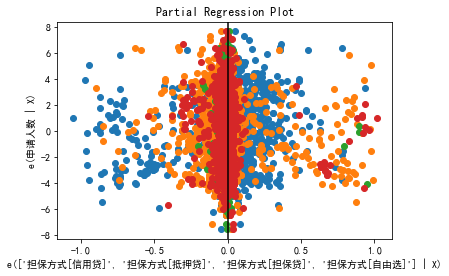

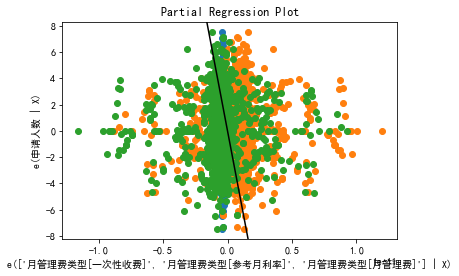

In [402]:
PlotParialRP('担保方式')
PlotParialRP('月管理费类型')

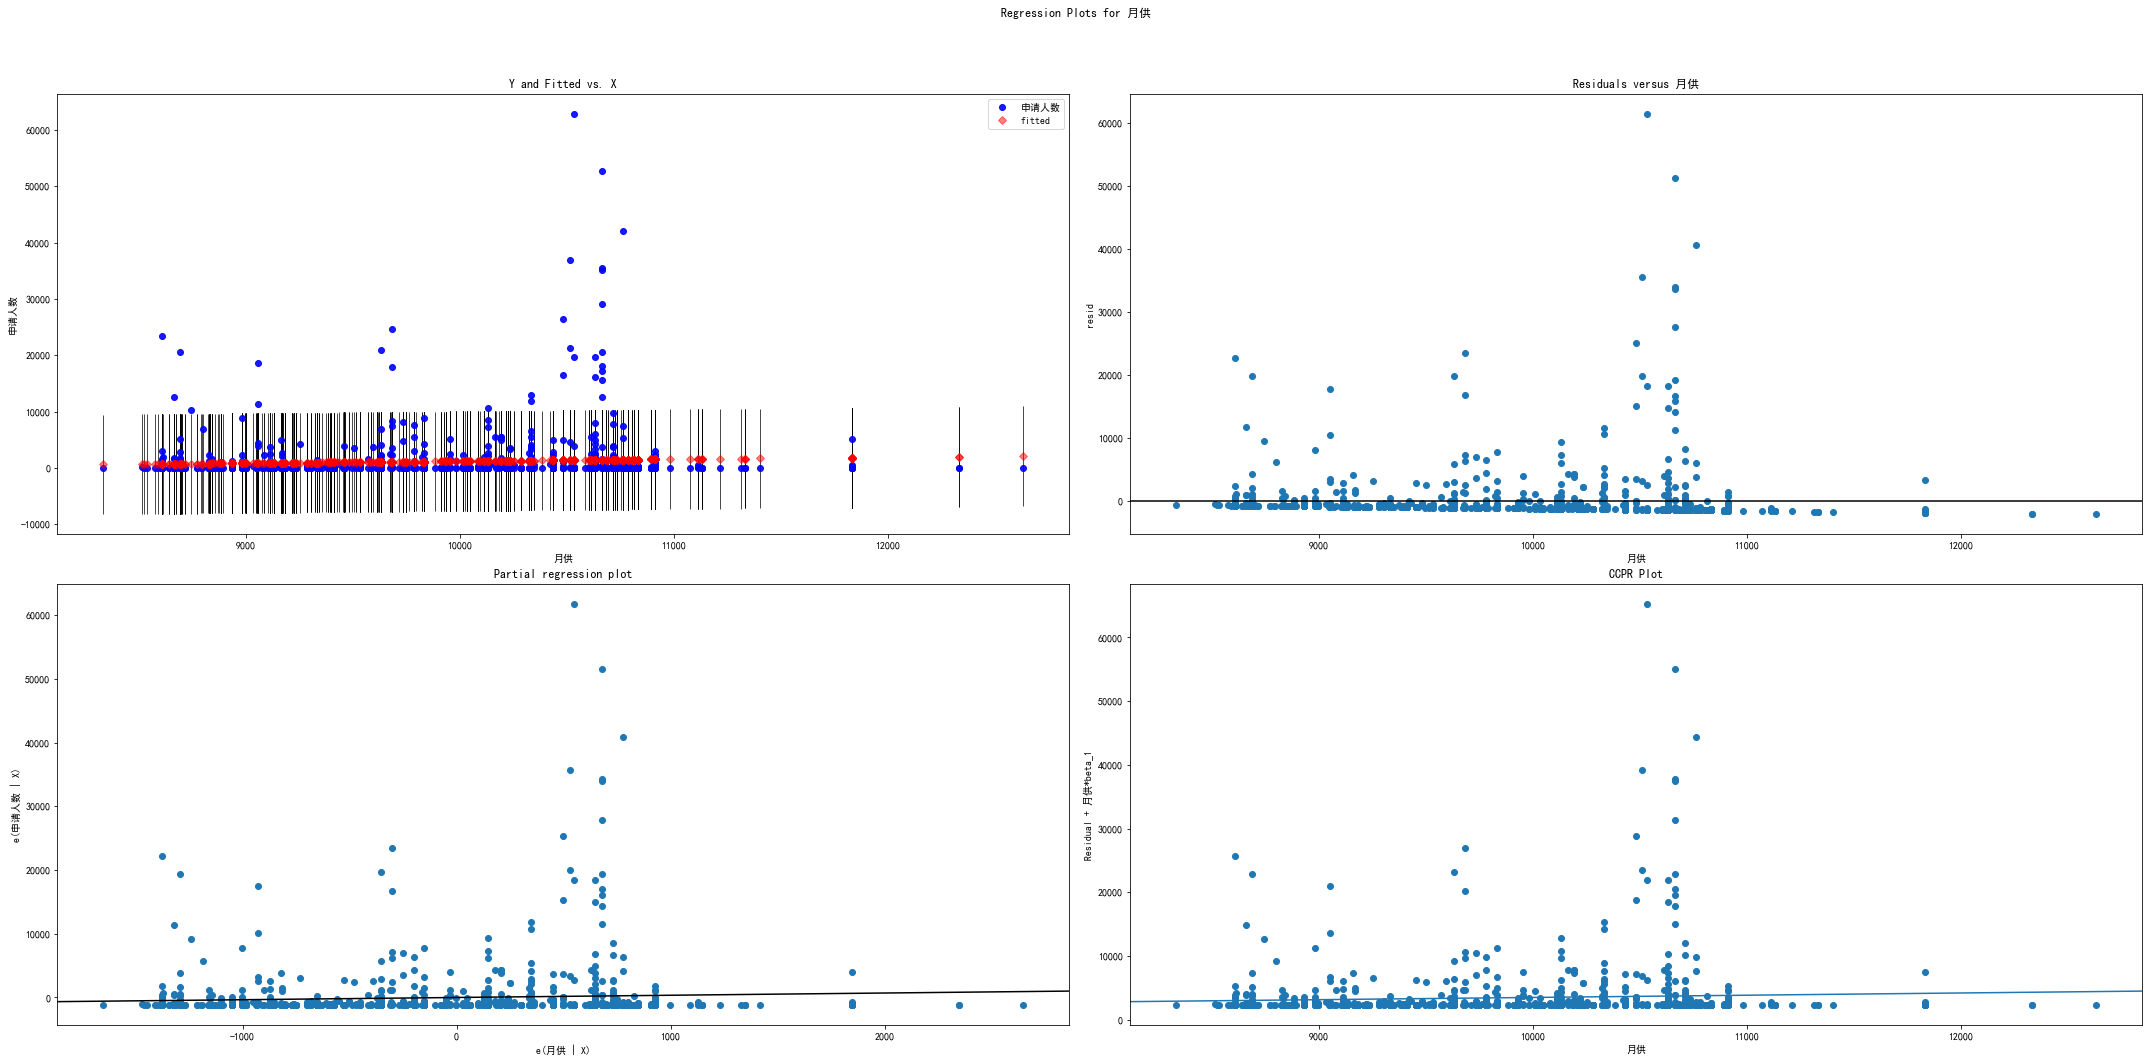

In [427]:
#训练模型
##一个自变量回归
one_lm = ols("""申请人数~ 月供""", data = all_data).fit()


fig = plt.figure(figsize=(30,15))
fig = sm.graphics.plot_regress_exog(one_lm, "月供", fig =fig)

#fig.savefig('./simple linear regression plots.jpg',dpi=300) #保存图片

In [428]:
# 前面的拟合结果很差，考虑加入更多的信息，也就是公司名称和申请条件

In [429]:
# 创建停用词列表
def stopwordslist():
    path = 'C:\\Users\WENDY\\Desktop\\消费者行为分析\\课业2019\\stop_words.txt'
    stopwords = [line.strip() for line in open(path).readlines()]
    return stopwords

In [430]:
# 对句子进行中文分词
def seg_depart(sentence, seg_list):
    # 对文档中的每一行进行中文分词
    if type(sentence) == int:
        sentence = ''
#    sentence_depart = jieba.cut(sentence.strip())
    sentence_depart = []
    sentence = pseg.cut(sentence.strip())
    for word, flag in sentence:
        if flag in seg_list:
            sentence_depart.append(word)
            
    # 创建一个停用词列表
    stopwords = stopwordslist()
    # 输出结果为outstr
    outstr = []
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                # sqtj 1759, gsmc 384
                if len(word) != 1:
                    outstr.append(word)
    return outstr

In [431]:
def getTextDict(text_list, text_dict):
    for word in text_list:
        if word not in text_dict.keys():
            text_dict[word] = 1
        else:
            text_dict[word] = text_dict[word] + 1
    return text_dict

In [432]:
sqtj_dict = {}
gsmc_dict = {}
for row in all_data.itertuples(index = True, name = 'Pandas'):
    sqtj = getattr(row, '申请条件')
    sqtj_seg_list = ['n', 'a']
    sqtj_list = seg_depart(sqtj, sqtj_seg_list)
    sqtj_dict = getTextDict(sqtj_list, sqtj_dict)
     
    gsmc = getattr(row, '公司名称')
    gsmc_seg_list = ['nt']
    gsmc_list = seg_depart(gsmc, gsmc_seg_list)
    gsmc_dict = getTextDict(gsmc_list, gsmc_dict)

In [433]:
print(len(sqtj_dict))

730


In [434]:
common_words = []
i = 1
weight = 100
for item in sorted(sqtj_dict.items(),key = lambda x:x[1],reverse = True):
    if i <= 30:
        common_words.append((item[0], 1))
        #weight = weight - 1
        i = i + 1

print(common_words)
print(len(common_words))

[('信用', 1), ('良好', 1), ('流水', 1), ('证明', 1), ('方可', 1), ('单位', 1), ('记录', 1), ('身份证', 1), ('银行', 1), ('年龄', 1), ('名下', 1), ('条件', 1), ('合同', 1), ('连续', 1), ('公积金', 1), ('稳定', 1), ('报告', 1), ('贷款', 1), ('公务员', 1), ('人士', 1), ('商品房', 1), ('员工', 1), ('公民', 1), ('车辆', 1), ('住址', 1), ('企业', 1), ('人员', 1), ('信用卡', 1), ('行业', 1), ('客户', 1)]
30


In [435]:
# 按照包含关键词的个数来进行打分
sqtj_list = all_data['申请条件']

scores = []
for i in range(len(sqtj_list)):
    sentence = sqtj_list[i]
    score = 0
    if sentence != 0:
        for word in common_words:
            if word[0] in sentence:
                score = score + word[1]
    else:
        score = 0
    scores.append(score)

    
all_data2 = all_data1.copy(deep=True)
all_data2['申请条件得分'] = scores

In [436]:
new_y2, new_x2 = dmatrices("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类型 + 月管理费利率 + 申请条件得分""", data = all_data2, return_type = 'dataframe')

new_x2.head()

,Intercept,城市[T.北京],城市[T.南京],城市[T.天津],城市[T.广州],城市[T.成都],城市[T.杭州],城市[T.济南],城市[T.深圳],城市[T.西安],...,月管理费类型[T.参考月利率],月管理费类型[T.月管理费],月供,还款总费用,期限最低范围,期限最高范围,放款日期,审批时间,月管理费利率,申请条件得分
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,9225.0,1.07,1.0,12.0,1.0,1.0,1.6,4.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,10046.0,2.06,1.0,120.0,1.0,1.0,3.0,3.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,9333.0,1.20,1.0,36.0,3.0,1.0,1.0,5.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,8885.0,1.06,1.0,12.0,15.0,10.0,1.0,4.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,9749.0,1.70,1.0,36.0,1.0,1.0,2.5,2.0


In [437]:
lm_new2 = sm.OLS(new_y2, new_x2).fit()
lm_new2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     7.789
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           2.81e-26
Time:                        12:05:53   Log-Likelihood:                -2592.2
No. Observations:                1046   AIC:                             5238.
Df Residuals:                    1019   BIC:                             5372.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -16.6907     14.397     -1.159      0.247     -44.942      11.561
城市[T.北京]            0.3235      0.396      0.818      0.414      -0.453       1.100
城市[T.南京]           -0.2867      0.385     -0.745      0.456      -1.042       0.468
城市[T.天津]           -0.3100      0.477     -0.650      0.516      -1.245       0.625
城市[T.广州]            0.1456      0.393      0.371      0.711      -0.625       0.916
城市[T.成都]           -0.7065      0.391     -1.806      0.071      -1.474       0.061
城市[T.杭州]            1.1758      0.455      2.582      0.010       0.282       2.069
城市[T.济南]           -1.1244      0.463     -2.431      0.015      -2.032      -0.217
城市[T.深圳]           -0.1419      0.369     -0.385      0.701      -0.866       0.582
城市[T.西安]           -0.4266      0.418     -1.020      0.308      -1.247       0.394
城市[T.重庆]           -0.6569      0.422     -1.556      0.120      -1.485       0.171
城市[T.青岛]           -0.6447      0.432     -1.491      0.136      -1.493       0.204
还款方式[T.到期还款]       -0.9095      0.497     -1.832      0.067      -1.884       0.065
还款方式[T.随借随还]       -0.8449      0.890     -0.950      0.342      -2.590       0.901
担保方式[T.抵押贷]        -0.6494      0.330     -1.966      0.050      -1.298      -0.001
担保方式[T.担保贷]        -1.5713      1.502     -1.046      0.296      -4.519       1.376
担保方式[T.自由选]        -1.8861      0.597     -3.158      0.002      -3.058      -0.714
月管理费类型[T.参考月利率]     0.0585      3.187      0.018      0.985      -6.196       6.313
月管理费类型[T.月管理费]      0.0152      3.150      0.005      0.996      -6.167       6.197
月供                  0.0022      0.002      1.309      0.191      -0.001       0.005
还款总费用              -1.7549      1.410     -1.245      0.213      -4.521       1.011
期限最低范围              0.0132      0.022      0.594      0.553      -0.030       0.057
期限最高范围              0.0072      0.005      1.533      0.126      -0.002       0.016
放款日期               -0.1398      0.057     -2.438      0.015      -0.252      -0.027
审批时间                0.2610      0.089      2.943      0.003       0.087       0.435
月管理费利率             -0.0002      0.307     -0.001      0.999      -0.603       0.603
申请条件得分              0.3298      0.034      9.812      0.000       0.264       0.396
==============================================================================
Omnibus:                      168.602   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.271
Skew:                           0.187   Prob(JB):                     2.44e-10
Kurtosis:                       2.064   Cond. No.                     1.61e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correct

In [438]:
# 公司名称和地址重合度

In [439]:
gsmc_list = all_data['公司名称']
cs_list = all_data['城市']

matchs = []
for i in range(len(gsmc_list)):
    cs = cs_list[i]
    if cs in gsmc_list[i]:
        match = 1
    else:
        match = 0
    matchs.append(match)

    
all_data3 = all_data2.copy(deep=True)
all_data3['契合度'] = matchs

In [440]:
new_y3, new_x3 = dmatrices("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类型 + 月管理费利率 + 申请条件得分 + 契合度""", data = all_data3, return_type = 'dataframe')


lm_new3 = sm.OLS(new_y3, new_x3).fit()
lm_new3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     7.497
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           7.69e-26
Time:                        12:05:58   Log-Likelihood:                -2592.2
No. Observations:                1046   AIC:                             5240.
Df Residuals:                    1018   BIC:                             5379.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -16.8869     14.421     -1.171      0.242     -45.184      11.411
城市[T.北京]            0.3259      0.396      0.823      0.411      -0.451       1.103
城市[T.南京]           -0.2767      0.387     -0.716      0.474      -1.035       0.482
城市[T.天津]           -0.2950      0.480     -0.615      0.539      -1.237       0.647
城市[T.广州]            0.1508      0.393      0.383      0.702      -0.621       0.923
城市[T.成都]           -0.6932      0.394     -1.759      0.079      -1.467       0.080
城市[T.杭州]            1.1783      0.456      2.586      0.010       0.284       2.072
城市[T.济南]           -1.1213      0.463     -2.422      0.016      -2.030      -0.213
城市[T.深圳]           -0.1370      0.370     -0.371      0.711      -0.862       0.588
城市[T.西安]           -0.4036      0.426     -0.947      0.344      -1.240       0.433
城市[T.重庆]           -0.6549      0.422     -1.551      0.121      -1.484       0.174
城市[T.青岛]           -0.6457      0.433     -1.493      0.136      -1.495       0.203
还款方式[T.到期还款]       -0.9103      0.497     -1.833      0.067      -1.885       0.064
还款方式[T.随借随还]       -0.8495      0.890     -0.954      0.340      -2.596       0.897
担保方式[T.抵押贷]        -0.6473      0.331     -1.958      0.051      -1.296       0.002
担保方式[T.担保贷]        -1.5760      1.503     -1.049      0.295      -4.525       1.373
担保方式[T.自由选]        -1.8606      0.604     -3.079      0.002      -3.046      -0.675
月管理费类型[T.参考月利率]     0.0703      3.189      0.022      0.982      -6.187       6.328
月管理费类型[T.月管理费]      0.0333      3.152      0.011      0.992      -6.153       6.219
月供                  0.0022      0.002      1.315      0.189      -0.001       0.005
还款总费用              -1.7664      1.411     -1.252      0.211      -4.535       1.002
期限最低范围              0.0128      0.022      0.574      0.566      -0.031       0.057
期限最高范围              0.0072      0.005      1.539      0.124      -0.002       0.016
放款日期               -0.1392      0.057     -2.424      0.016      -0.252      -0.027
审批时间                0.2598      0.089      2.925      0.004       0.086       0.434
月管理费利率             -0.0051      0.308     -0.017      0.987      -0.610       0.599
申请条件得分              0.3294      0.034      9.786      0.000       0.263       0.395
契合度                 0.0994      0.354      0.281      0.779      -0.594       0.793
==============================================================================
Omnibus:                      167.456   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.163
Skew:                           0.187   Prob(JB):                     2.57e-10
Kurtosis:                       2.065   Cond. No.                     1.61e+06
==============================================================================

Warn

In [457]:
# 一个好名字的影响
common_names = []
i = 1
weight = 10
for item in sorted(gsmc_dict.items(),key = lambda x:x[1],reverse = True):
    if i <= 10:
        common_names.append((item[0], weight))
        weight = weight - 1
        i = i + 1

print(common_names)
print(len(common_names))

[('花旗银行', 10), ('中信银行', 9), ('北京分行', 8), ('商务信息', 7), ('华夏银行', 6), ('汇中', 5), ('民信', 4), ('民生银行', 3), ('商业银行', 2), ('中国银行', 1)]
10


In [458]:
# 按照包含关键词的个数来进行打分
gsmc_list = all_data['公司名称']

mingzi = []
for i in range(len(gsmc_list)):
    mz = gsmc_list[i]
    score = 0
    for word in common_names:
        if word[0] in mz:
                score = score + word[1]
    mingzi.append(score)

    
all_data4 = all_data3.copy(deep=True)
all_data4['好名字'] = mingzi

In [459]:
new_y4, new_x4 = dmatrices("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类型 + 月管理费利率 + 申请条件得分 + 契合度 + 好名字""", data = all_data4, return_type = 'dataframe')

new_x4.head()

lm_new4 = sm.OLS(new_y4, new_x4).fit()
lm_new4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     8.101
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           2.78e-29
Time:                        12:17:12   Log-Likelihood:                -2581.7
No. Observations:                1046   AIC:                             5221.
Df Residuals:                    1017   BIC:                             5365.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.3382     14.337     -0.791      0.429     -39.471      16.794
城市[T.北京]            0.1159      0.395      0.294      0.769      -0.659       0.891
城市[T.南京]           -0.2717      0.383     -0.709      0.478      -1.023       0.480
城市[T.天津]           -0.3337      0.475     -0.702      0.483      -1.267       0.599
城市[T.广州]            0.1682      0.390      0.432      0.666      -0.596       0.933
城市[T.成都]           -0.6993      0.390     -1.791      0.074      -1.465       0.067
城市[T.杭州]            1.1348      0.451      2.514      0.012       0.249       2.021
城市[T.济南]           -1.1662      0.459     -2.543      0.011      -2.066      -0.266
城市[T.深圳]           -0.0648      0.366     -0.177      0.860      -0.784       0.654
城市[T.西安]           -0.3936      0.422     -0.932      0.351      -1.222       0.435
城市[T.重庆]           -0.6944      0.418     -1.660      0.097      -1.516       0.127
城市[T.青岛]           -0.6804      0.429     -1.588      0.113      -1.521       0.161
还款方式[T.到期还款]       -0.8122      0.493     -1.649      0.099      -1.779       0.154
还款方式[T.随借随还]       -0.9040      0.882     -1.025      0.306      -2.634       0.826
担保方式[T.抵押贷]        -0.5828      0.328     -1.778      0.076      -1.226       0.060
担保方式[T.担保贷]        -1.5406      1.489     -1.035      0.301      -4.462       1.381
担保方式[T.自由选]        -1.5612      0.602     -2.592      0.010      -2.743      -0.379
月管理费类型[T.参考月利率]    -0.4979      3.161     -0.157      0.875      -6.701       5.706
月管理费类型[T.月管理费]     -0.2000      3.123     -0.064      0.949      -6.328       5.928
月供                  0.0015      0.002      0.926      0.355      -0.002       0.005
还款总费用              -1.1326      1.404     -0.806      0.420      -3.889       1.623
期限最低范围              0.0152      0.022      0.687      0.492      -0.028       0.059
期限最高范围              0.0080      0.005      1.720      0.086      -0.001       0.017
放款日期               -0.1458      0.057     -2.564      0.010      -0.257      -0.034
审批时间                0.2729      0.088      3.099      0.002       0.100       0.446
月管理费利率             -0.0532      0.305     -0.174      0.862      -0.652       0.546
申请条件得分              0.3154      0.033      9.422      0.000       0.250       0.381
契合度                 0.1643      0.351      0.469      0.639      -0.524       0.852
好名字                 0.1865      0.041      4.531      0.000       0.106       0.267
==============================================================================
Omnibus:                      155.428   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.644
Skew:                           0.200   Prob(JB):                     3.33e-10
Kurtosis:                       2.082   Cond. No.                     1.62e+06


In [453]:
new_y3, new_x3 = dmatrices("""申请人数~ 好名字""", data = all_data4, return_type = 'dataframe')

new_x3.head()

lm_new3 = sm.OLS(new_y3, new_x3).fit()
lm_new3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     32.86
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           1.30e-08
Time:                        12:07:35   Log-Likelihood:                -2670.8
No. Observations:                1046   AIC:                             5346.
Df Residuals:                    1044   BIC:                             5355.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3206      0.101     32.951      0.000       3.123       3.518
好名字            0.2306      0.040      5.732      0.000       0.152       0.309
==============================================================================
Omnibus:                      800.741   Durbin-Watson:                   1.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.319
Skew:                           0.243   Prob(JB):                     1.20e-16
Kurtosis:                       1.797   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

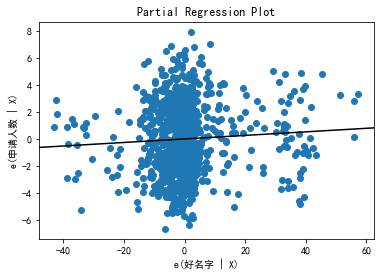

In [446]:
plot_names2 = plot_names + ['申请条件得分',
                             '契合度',
                             '好名字']

PlotParialRP('好名字', all_data4, plot_names2)